In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import json
import os
import matplotlib.pyplot as plt

seed_number = 42
np.random.seed(seed_number)
tf.random.set_seed(seed_number)
random.seed(seed_number)

# SMAPE calculation function
def smape(yTrue, yPred):
    denominator = (np.abs(yTrue) + np.abs(yPred))
    smape_value = np.mean(2 * np.abs(yPred - yTrue) / np.where(denominator == 0, 1, denominator)) * 100
    return smape_value

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare univariate data for LSTM input
def prepare_data(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input)])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

# Build the LSTM Model
def build_model(n_input, layer, unit, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(n_input, 1)))
    
    model.add(LSTM(unit[0], activation='relu', return_sequences=(layer > 1)))
    model.add(Dropout(dropout_rate))
    
    for i in range(1, layer):
        model.add(LSTM(unit[min(i, len(unit)-1)], activation='relu', return_sequences=(i < layer-1)))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Evaluate the model performance with confidence intervals
def evaluate_model(train, test, n_input, layer, unit, dropout_rate, scaler, epochs):
    train_x, train_y = prepare_data(train, n_input)
    test_x, test_y = prepare_data(test, n_input)
    
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    test_x = test_x.reshape((test_x.shape[0], test_x.shape[1], 1))
    
    model = build_model(n_input, layer, unit, dropout_rate)
    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(train_x, train_y, epochs=epochs, batch_size=8, validation_split=0.2, callbacks=[es], verbose=0)
    
    n_iterations = 20
    predictions_mc = np.array([model(test_x, training=True) for _ in range(n_iterations)])
    
    predictions_mean = np.mean(predictions_mc, axis=0).reshape(-1, 1)
    predictions_std = np.std(predictions_mc, axis=0).reshape(-1, 1)
    
    lower_bound = predictions_mean - 1.96 * predictions_std
    upper_bound = predictions_mean + 1.96 * predictions_std
    
    predictions_mean = scaler.inverse_transform(predictions_mean)
    lower_bound = scaler.inverse_transform(lower_bound)
    upper_bound = scaler.inverse_transform(upper_bound)
    y_test_inv = scaler.inverse_transform(test_y.reshape(-1, 1))
    
    smape_value = smape(y_test_inv, predictions_mean)
    mae = mean_absolute_error(y_test_inv, predictions_mean)
    rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_mean))
    
    return smape_value, mae, rmse, predictions_mean, y_test_inv, lower_bound, upper_bound

# Main execution for univariate forecasting
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)

    attacks = ['DDoS-ALL', 'Phishing-ALL', 'Ransomware-ALL', 'Password Attack-ALL', 'SQL Injection-ALL', 'Account Hijacking-ALL', 
           'Defacement-ALL', 'Trojan-ALL', 'Vulnerability-ALL', 'Zero-day-ALL', 'Malware-ALL', 'Advanced persistent threat-ALL', 
           'XSS-ALL', 'Data Breach-ALL', 'Disinformation/Misinformation-ALL', 'Targeted Attack-ALL','Adware-ALL',
           'Brute Force Attack-ALL', 'Malvertising-ALL', 'Backdoor-ALL', 'Botnet-ALL', 'Cryptojacking-ALL',
           'Worms-ALL', 'Spyware-ALL']

    # Create directories for saving best parameters and plots
    output_param_dir = 'univariateparam25'
    output_plot_dir = 'univariateplot25'
    os.makedirs(output_param_dir, exist_ok=True)
    os.makedirs(output_plot_dir, exist_ok=True)

    # Hyperparameters for random search
    alphas = [0.05, 0.2, 0.5, 0.7, 1]
    betas = [0.3, 0.5, 0.7, 1]
    lags = [1, 3, 6, 12]
    epochs_list = [100, 200, 300, 400, 500]
    dropout_rates = [0.1, 0.15, 0.2]

    # Loop through each attack type (univariate forecast for each)
    for attack in attacks:
        print(f"Processing attack: {attack}")

        # Select the data for the current attack (only one column for univariate)
        attack_data = data[attack].values.reshape(-1, 1)

        best_smape = float('inf')
        best_params = {}
        best_model = None

        iterations = 100

        # Iterate through random hyperparameters to find the best configuration
        for iteration in range(iterations):
            print(f"Iteration {iteration + 1} out of {iterations}")

            # Randomly generate hyperparameters
            alpha = random.choice(alphas)
            beta = random.choice(betas)
            n_input = random.choice(lags)
            n_epochs = random.choice(epochs_list)
            layer = random.choice([1, 2, 3])
            dropout_rate = random.choice(dropout_rates)

            if alpha != 1 and beta != 1:
                smoothed_data = double_exponential_smoothing(attack_data.flatten(), alpha, beta).reshape(-1, 1)
            elif alpha != 1 and beta == 1:
                smoothed_data = exponential_smoothing(attack_data.flatten(), alpha).reshape(-1, 1)
            else:
                smoothed_data = attack_data

            # Scale the smoothed data
            scaler = RobustScaler()
            scaled_data = scaler.fit_transform(smoothed_data)

            # Split into train and test sets
            train_size = len(scaled_data) - 36
            train, test = scaled_data[:train_size], scaled_data[train_size:]
            test_dates = data.index[train_size:]

            if layer == 1:
                units = [random.choice([16, 32])]
            elif layer == 2:
                units = [random.choice([100, 200]), random.choice([50, 100])]
            else:
                units = [random.choice([200, 400]), random.choice([100, 200]), random.choice([50, 100])]

            # Evaluate the model with the current hyperparameters
            smape_value, mae, rmse, predictions_mean, y_test_inv, lower_bound, upper_bound = evaluate_model(
                train, test, n_input, layer, units, dropout_rate, scaler, n_epochs
            )

            # Save the best model parameters
            if smape_value < best_smape:
                best_smape = smape_value
                best_params = {
                    'alpha': alpha, 'beta': beta, 'n_input': n_input, 'n_epochs': n_epochs,
                    'layer': layer, 'units': units, 'dropout_rate': dropout_rate
                }
                best_predictions_mean = predictions_mean
                best_y_test_inv = y_test_inv
                best_lower_bound = lower_bound
                best_upper_bound = upper_bound

        # Save the best parameters for the current attack in a separate JSON file
        file_path = os.path.join(output_param_dir, f'{attack}_best_params.json')
        data_to_save = {
            "SMAPE": best_smape,
            "Best Parameters": best_params
        }
        with open(file_path, 'w') as f:
            json.dump(data_to_save, f)

        # Adjust test_dates to match the length of best_y_test_inv
        test_dates = test_dates[-len(best_y_test_inv):]

        print(f"Best parameters for {attack} saved to {file_path}.")
        print(f"Best SMAPE for {attack}: {best_smape}")
        print(f"Best MAE: {mae}")
        print(f"Best RMSE: {rmse}")

        # Plot the actual vs predicted values and save the plot
        plt.figure(figsize=(10, 6))

        # Plot actual values predicted mean values
        plt.plot(test_dates, best_y_test_inv, label='Actual', color='blue', linewidth=2)
        plt.plot(test_dates, best_predictions_mean, label='Predicted Mean', color='red', linewidth=2)

        # Plot the confidence intervals (upper and lower bounds)
        plt.fill_between(
            test_dates,
            best_lower_bound.flatten(),   # Lower bound of the 95% confidence interval
            best_upper_bound.flatten(),   # Upper bound of the 95% confidence interval
            color='green', alpha=0.3, label='95% Confidence Interval'
        )

        # Add titles, labels, and legend
        plt.title(f'{attack} (SMAPE: {best_smape:.2f}, Univariate)')
        plt.xlabel('Time')
        plt.ylabel('Incident Count')
        plt.legend()

        # Save the plot
        plot_path = os.path.join(output_plot_dir, f'{attack}_actual_vs_predicted.png')
        plt.savefig(plot_path)
        plt.close()

        print(f"Plot for {attack} saved to {plot_path}.")

print("Best parameters for all attacks have been saved individually.")


Processing attack: SQL Injection-ALL
Iteration 1 out of 100
Iteration 2 out of 100
Iteration 3 out of 100


KeyboardInterrupt: 

Forecasting for attack: Targeted Attack-ALL


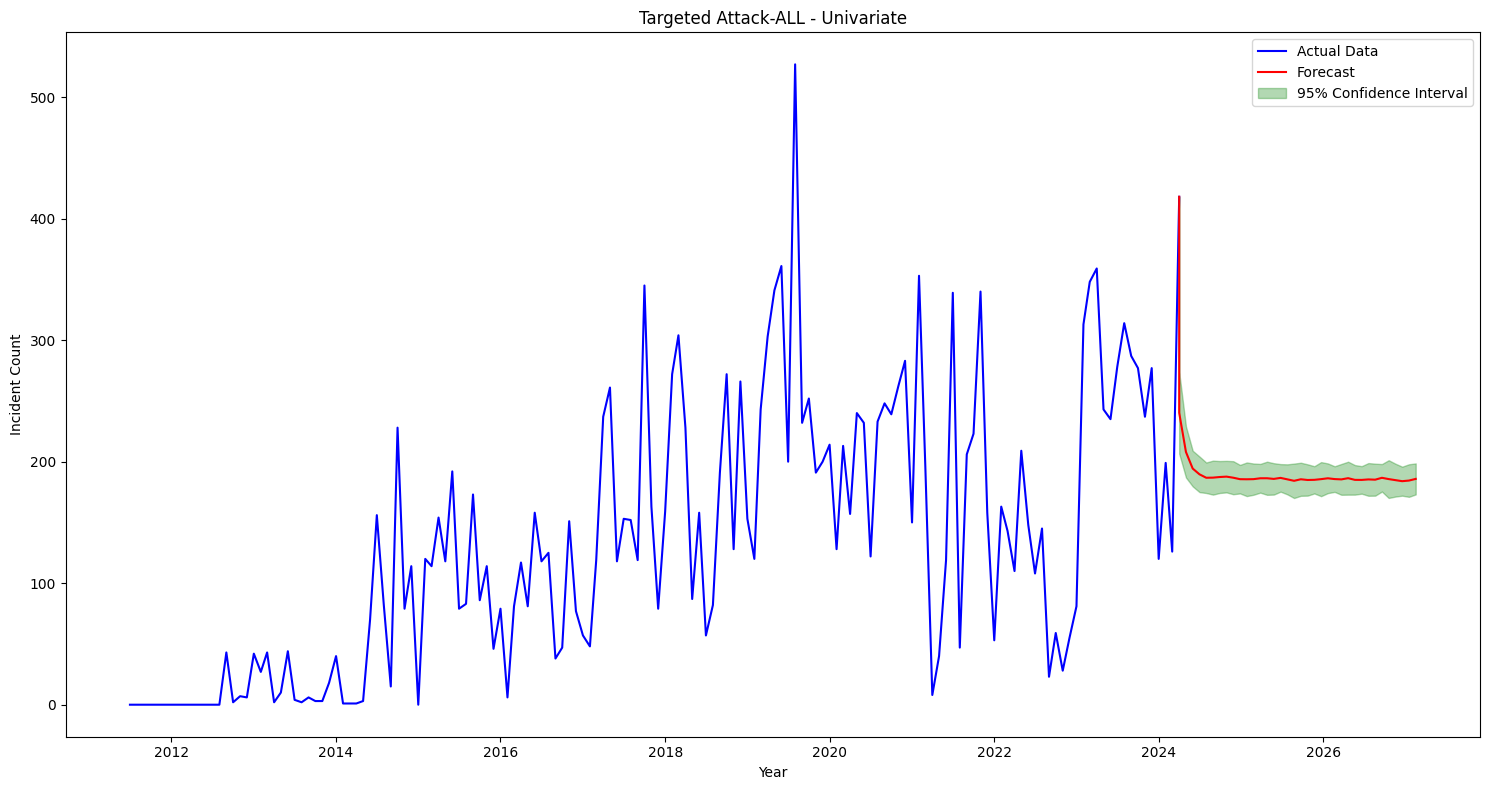

Forecast plot for Targeted Attack-ALL saved to univariate_forecast_plots_36months_U/Targeted Attack-ALL_forecast_mc_dropout.png.
Forecasting for attack: Adware-ALL


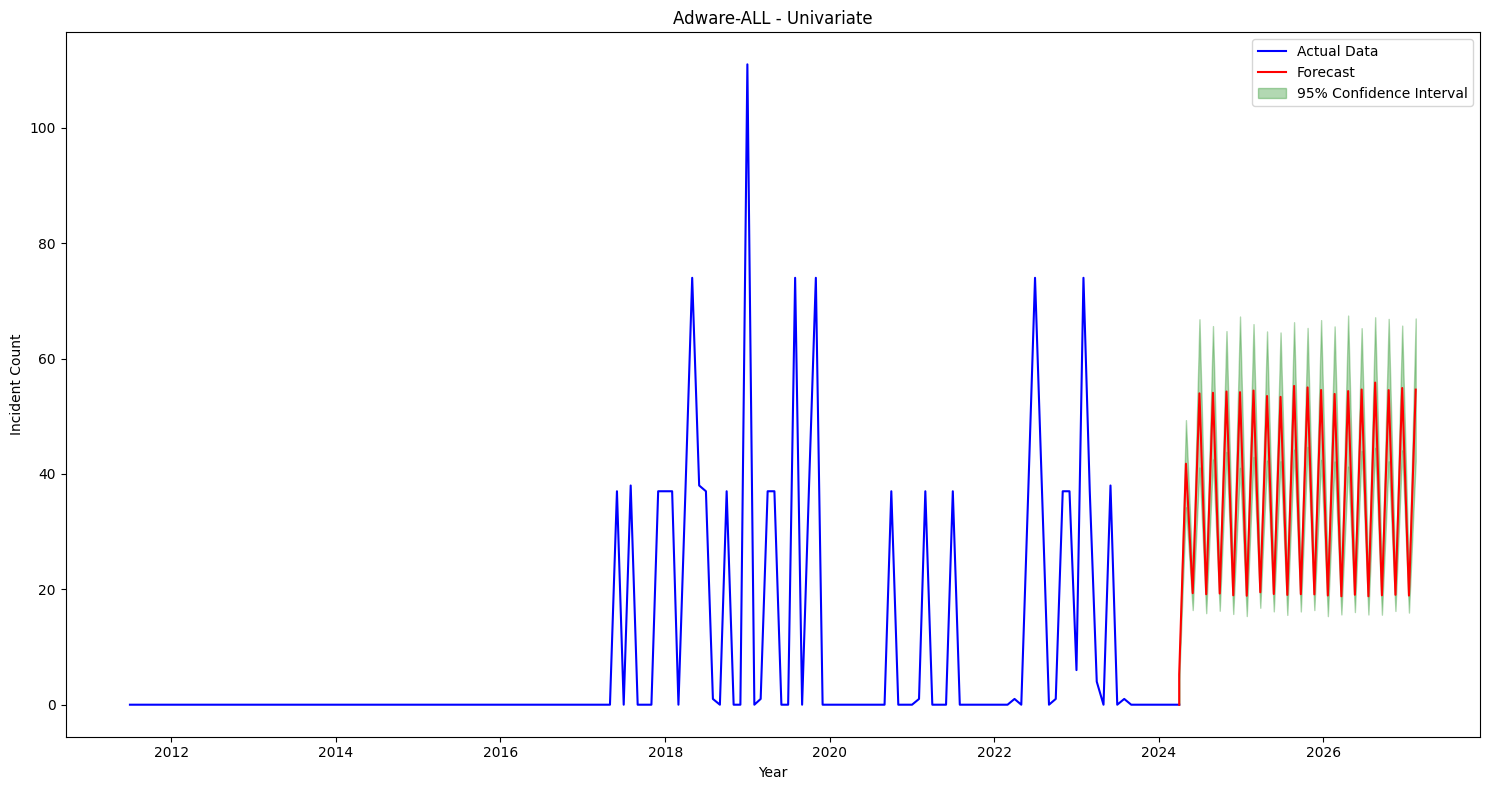

Forecast plot for Adware-ALL saved to univariate_forecast_plots_36months_U/Adware-ALL_forecast_mc_dropout.png.
Forecasting for attack: Brute Force Attack-ALL


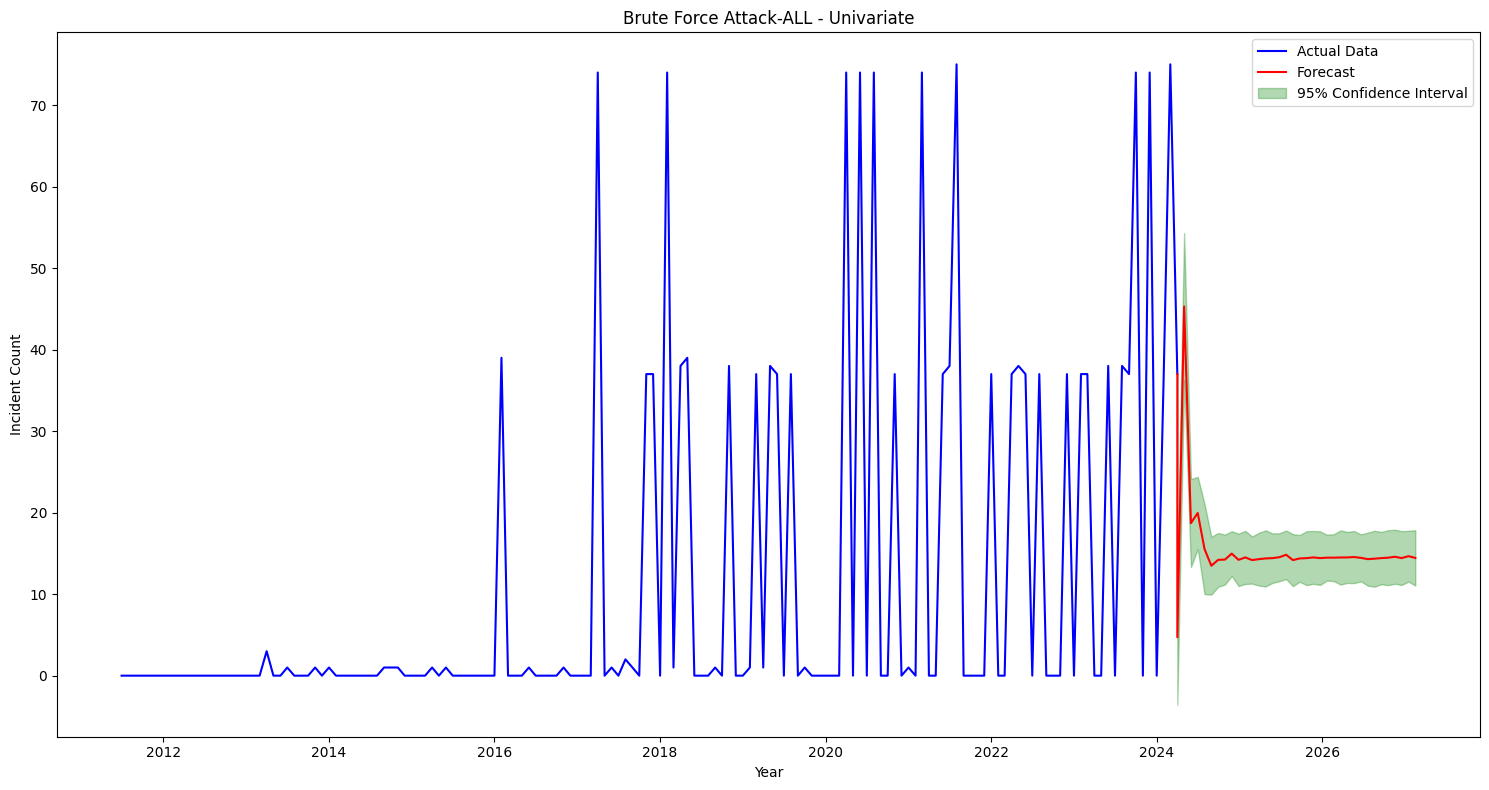

Forecast plot for Brute Force Attack-ALL saved to univariate_forecast_plots_36months_U/Brute Force Attack-ALL_forecast_mc_dropout.png.
Forecasting for attack: Malvertising-ALL


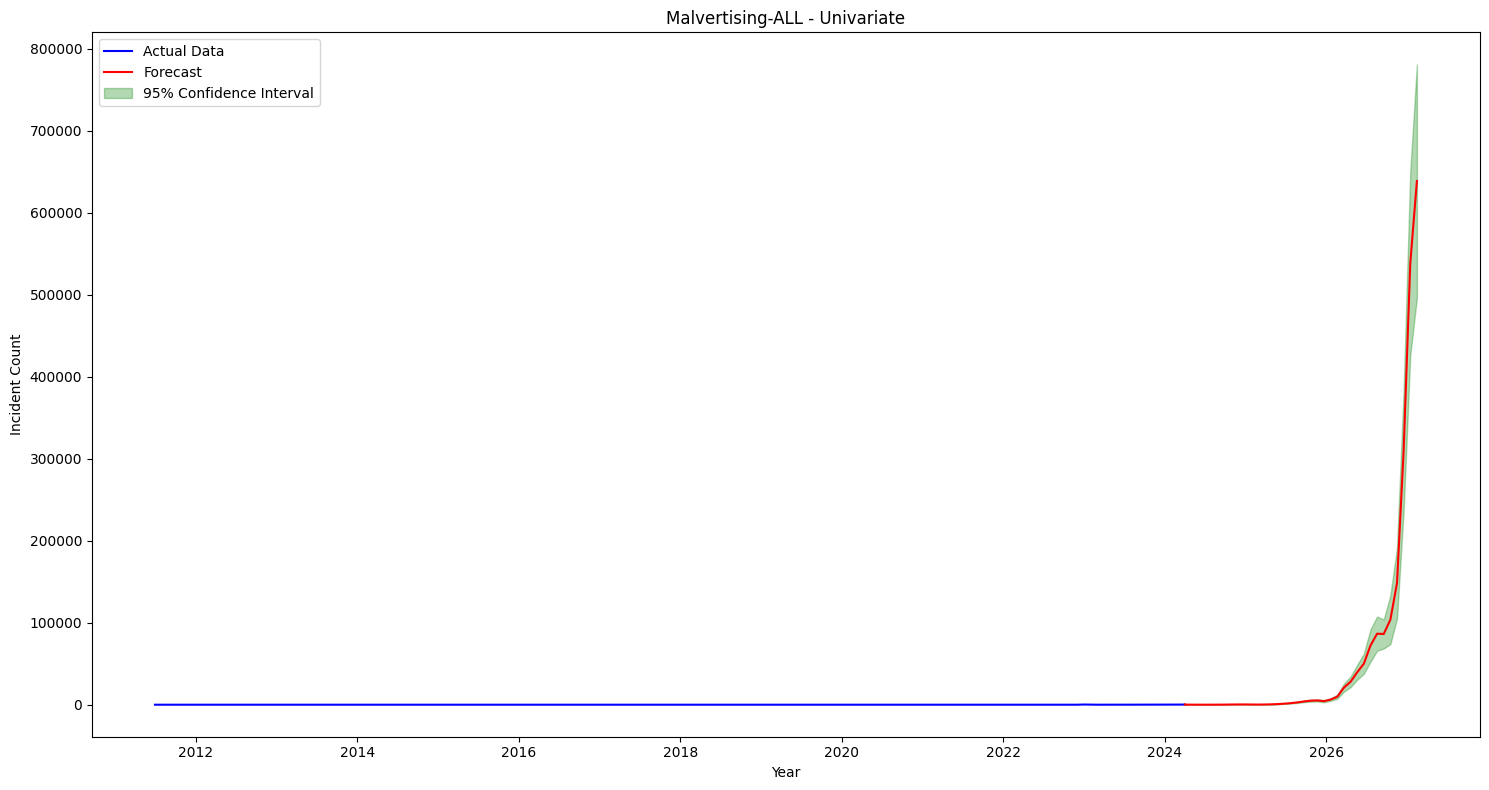

Forecast plot for Malvertising-ALL saved to univariate_forecast_plots_36months_U/Malvertising-ALL_forecast_mc_dropout.png.
Forecasting for attack: Backdoor-ALL


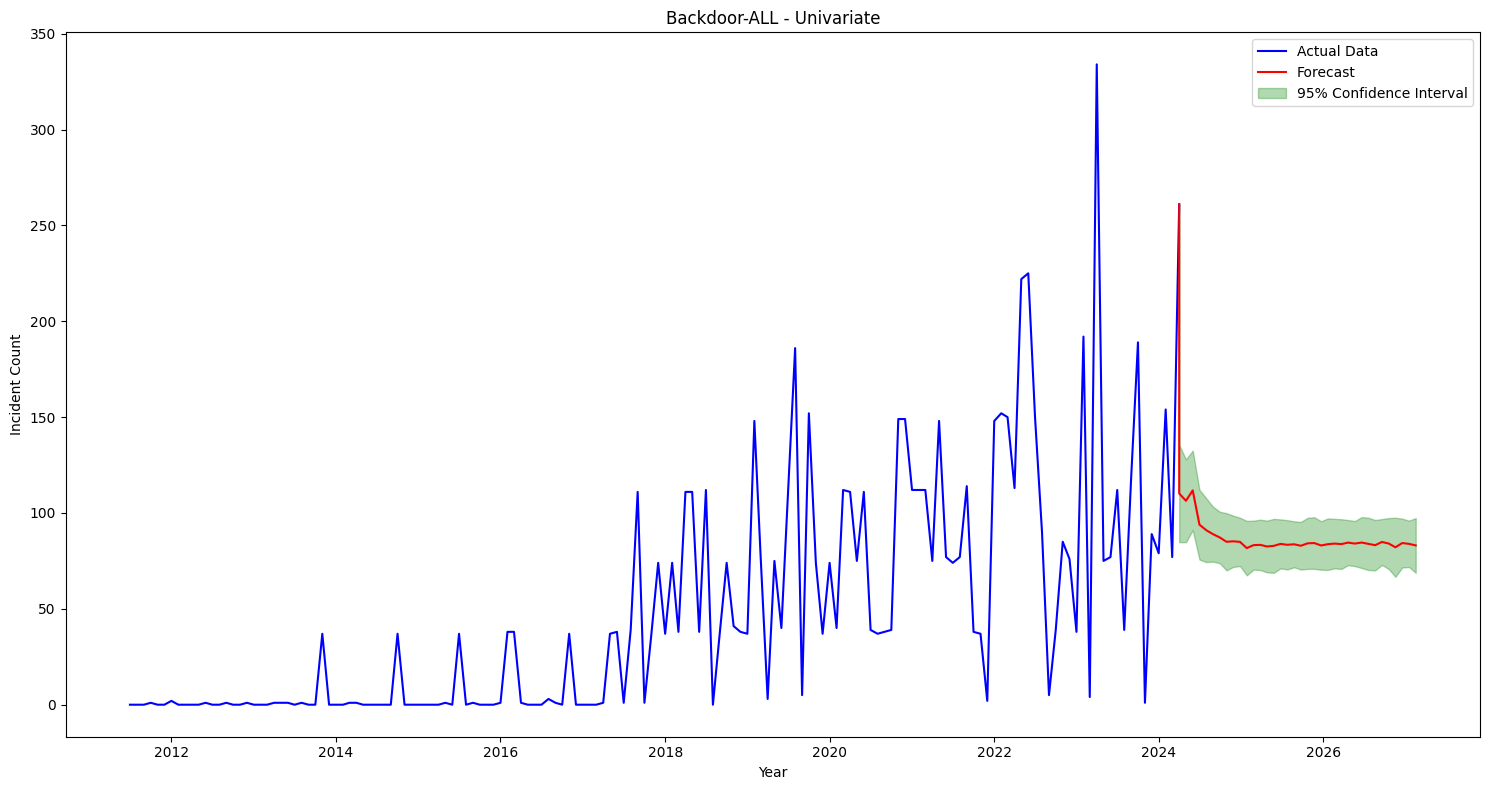

Forecast plot for Backdoor-ALL saved to univariate_forecast_plots_36months_U/Backdoor-ALL_forecast_mc_dropout.png.
Forecasting for attack: Botnet-ALL


ValueError: Input 0 of layer "lstm_40" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 200)

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from sklearn.preprocessing import RobustScaler
import os
import json
import matplotlib.pyplot as plt
from datetime import timedelta

seed_number = 42
np.random.seed(seed_number)
tf.random.set_seed(seed_number)
random.seed(seed_number)

# SMAPE calculation function
def smape(yTrue, yPred):
    denominator = (np.abs(yTrue) + np.abs(yPred))
    smape_value = np.mean(2 * np.abs(yPred - yTrue) / np.where(denominator == 0, 1, denominator)) * 100
    return smape_value

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Double Exponential Smoothing
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return np.array(result)

# Prepare univariate data for LSTM input
def prepare_data(data, n_input):
    X, y = [], []
    for i in range(len(data) - n_input):
        X.append(data[i:(i + n_input)])
        y.append(data[i + n_input])
    return np.array(X), np.array(y)

# Build the LSTM Model with Monte Carlo Dropout
def build_mc_dropout_model(n_input, units, dropout_rate):
    model = Sequential()
    model.add(Input(shape=(n_input, 1)))
    
    model.add(LSTM(units[0], activation='relu', return_sequences=(len(units) > 1)))
    model.add(Dropout(dropout_rate))
    
    for unit in units[1:]:
        model.add(LSTM(unit, activation='relu', return_sequences=False))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer='adam', loss='mse')
    return model

# Monte Carlo Dropout prediction function
def mc_dropout_predict(model, X, n_iter=100):
    predictions = np.array([model(X, training=True) for _ in range(n_iter)])  # Dropout enabled during prediction
    return predictions.mean(axis=0), predictions.std(axis=0)

# Generate future dates for forecast
def generate_future_dates(start_date, periods):
    return [start_date + timedelta(days=i*30) for i in range(periods)]  # Assuming monthly data

# Step-by-step forecasting with Monte Carlo Dropout
def step_by_step_mc_dropout_forecasting(attack_data, model, scaler, n_input, forecast_horizon, n_iterations=100):
    last_sequence = attack_data[-n_input:].reshape(1, n_input, 1)  # Last n_input values for forecast
    forecasts = []
    lower_bounds = []
    upper_bounds = []

    for _ in range(forecast_horizon):
        # Predict the next time step using Monte Carlo Dropout
        next_prediction_mean, next_prediction_std = mc_dropout_predict(model, last_sequence, n_iter=n_iterations)
        forecast = next_prediction_mean[0, 0]
        forecasts.append(forecast)

        # Calculate confidence intervals (95%)
        lower_bound = forecast - 1.96 * next_prediction_std[0, 0]
        upper_bound = forecast + 1.96 * next_prediction_std[0, 0]
        lower_bounds.append(lower_bound)
        upper_bounds.append(upper_bound)

        # Roll the sequence forward by adding the predicted value
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1, 0] = forecast

    # Inverse transform the forecasted values back to the original scale
    forecasts = np.array(forecasts).reshape(-1, 1)
    forecasts_inv = scaler.inverse_transform(forecasts).flatten()

    lower_bounds = np.array(lower_bounds).reshape(-1, 1)
    upper_bounds = np.array(upper_bounds).reshape(-1, 1)
    
    lower_bounds_inv = scaler.inverse_transform(lower_bounds).flatten()
    upper_bounds_inv = scaler.inverse_transform(upper_bounds).flatten()

    return forecasts_inv, lower_bounds_inv, upper_bounds_inv

# Plot forecast and actual data with overlap
def forecast_univariate_mc_dropout(target_variable, attack_data, scaler, model, forecast_horizon, data, last_date, output_plot_dir):
    # Step-by-step forecast generation with Monte Carlo Dropout
    forecasts_inv, lower_bounds_inv, upper_bounds_inv = step_by_step_mc_dropout_forecasting(
        attack_data, model, scaler, best_params['n_input'], forecast_horizon
    )

    # Generate future dates for the forecast
    future_dates = generate_future_dates(last_date, forecast_horizon)

    # Seamless overlap: Append the last historical data point to the beginning of the forecast for smooth plot
    seamless_forecast = np.insert(forecasts_inv, 0, data[target_variable].iloc[-1])
    lower_bounds_inv = np.insert(lower_bounds_inv, 0, data[target_variable].iloc[-1])
    upper_bounds_inv = np.insert(upper_bounds_inv, 0, data[target_variable].iloc[-1])

    # Plot historical data and forecast with overlap and confidence intervals
    plt.figure(figsize=(15, 8))
    plt.plot(data.index, data[target_variable], label='Actual Data', color='blue', linestyle='-')
    plt.plot([last_date] + future_dates, seamless_forecast, label='Forecast', color='red', linestyle='-')
    plt.fill_between([last_date] + future_dates, lower_bounds_inv, upper_bounds_inv, color='green', alpha=0.3, label='95% Confidence Interval')

    plt.title(f'{target_variable} - Univariate')
    plt.xlabel('Year')
    plt.ylabel('Incident Count')
    plt.legend()
    
    plt.tight_layout()
    
    # Save the plot
    plot_name = f'{target_variable}_forecast_mc_dropout.png'
    plot_path = os.path.join(output_plot_dir, plot_name)
    plt.savefig(plot_path)
    plt.show()
    
    print(f"Forecast plot for {target_variable} saved to {plot_path}.")

# Main execution for univariate forecasting with MC Dropout
if __name__ == "__main__":
    # Load and preprocess data
    data = pd.read_csv('FinalDataset.csv')
    data['Date'] = pd.to_datetime(data['Date'], format='%b-%y')
    data.set_index('Date', inplace=True)

    attacks = [  'Targeted Attack-ALL','Adware-ALL',
           'Brute Force Attack-ALL', 'Malvertising-ALL', 'Backdoor-ALL', 'Botnet-ALL', 'Cryptojacking-ALL',
           'Worms-ALL', 'Spyware-ALL']

    param_dir = 'univariateparam25'
    output_plot_dir = 'univariate_forecast_plots_36months_U'
    os.makedirs(output_plot_dir, exist_ok=True)

    n_forecast = 36

    for attack in attacks:
        print(f"Forecasting for attack: {attack}")

        # Load best parameters
        with open(os.path.join(param_dir, f'{attack}_best_params.json'), 'r') as f:
            best_params = json.load(f)['Best Parameters']

        attack_data = data[attack].values.reshape(-1, 1)
        scaler = RobustScaler()
        attack_data_scaled = scaler.fit_transform(attack_data)

        # Build the model using the best hyperparameters with Monte Carlo Dropout
        model = build_mc_dropout_model(best_params['n_input'], best_params['units'], best_params['dropout_rate'])

        # Prepare data for model training
        X_train, y_train = prepare_data(attack_data_scaled, best_params['n_input'])
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

        # Train the model
        model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=40, verbose=0)

        # Forecast future values using Monte Carlo Dropout
        forecast_univariate_mc_dropout(attack, attack_data_scaled, scaler, model, n_forecast, data, data.index[-1], output_plot_dir)

print("Univariate forecasting with MC Dropout and overlap completed for all attacks.")
